<a href="https://colab.research.google.com/github/marcinwolter/GammaFactory/blob/main/tracks_in_magnetic_field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Charged particles in constant magnetic fields**

*Marcin Wolter, February 2021*

The equation of motion for a charged particle in a magnetic field is as follows:

$\frac{d\vec{v}}{dt}=qm(\vec{v} \times \vec{B} )$



Let's see how we can implement this using the integrators found in the scientific python stack.



In [400]:
# imports
import numpy as np
from scipy.integrate import ode

Here we define the magnetic field B

In [401]:
def B(x):
  '''
  Bx = 0
  By = 0
  Bz = 1
  '''
  # constant toroidal magnetic field
  B0 = 0.055 #0.05
  B1 = 0.13 #0.12
  R  = 30

  z_low = 10
  z_high= 30

  z_low_quad_1 = 40
  z_high_quad_1 = 70

  z_low_quad_2 = 80
  z_high_quad_2 = 110

  r = np.sqrt(x[0]*x[0] + x[1]*x[1])

  if x[2]>z_low and x[2]<z_high:
    
    sin_phi = x[1]/r
    cos_phi = x[0]/r
    
    if r<R:
      # small toroidal magnet
      Bx =  -B0*sin_phi
      By =   B0*cos_phi
      Bz =   0
    else:
      # big toroidal magnet
      Bx =   B1*sin_phi
      By =  -B1*cos_phi
      Bz =   0        

  else:
    Bx = 0
    By = 0
    Bz = 0
  
  return [Bx,By,Bz]

'''
  elif  x[2]>z_low_quad_1 and x[2]<z_high_quad_1 and r<R:
    # quadruple magnet
    # Bx = K*y   By = K*x
    Bx = 0.0003*x[1]
    By = 0.0003*x[0]
    Bz = 0
  elif  x[2]>z_low_quad_2 and x[2]<z_high_quad_2 and r<R:
    # quadruple magnet
    # Bx = K*y   By = K*x
    Bx = -0.0003*x[1]
    By = -0.0003*x[0]
    Bz = 0
'''  

'\n  elif  x[2]>z_low_quad_1 and x[2]<z_high_quad_1 and r<R:\n    # quadruple magnet\n    # Bx = K*y   By = K*x\n    Bx = 0.0003*x[1]\n    By = 0.0003*x[0]\n    Bz = 0\n  elif  x[2]>z_low_quad_2 and x[2]<z_high_quad_2 and r<R:\n    # quadruple magnet\n    # Bx = K*y   By = K*x\n    Bx = -0.0003*x[1]\n    By = -0.0003*x[0]\n    Bz = 0\n'

To use ode, we need to define the derivatives of velocity, which is computed using the Lorentz force and of position, which is just velocity:

In [402]:
def newton(t, Y, q, m):
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    """
   
    #x, y, z = Y[0], Y[1], Y[2]
    #u, v, w = Y[3], Y[4], Y[5]

    alpha = q / m * np.cross(Y[3:],B(Y[:3]))

    Y_out = np.concatenate((Y[3:],alpha))

    return Y_out
    #return np.array([u, v, w, alpha[0], alpha[1], alpha[2]])

In [403]:
r = ode(newton).set_integrator('dopri5')

Let's now set the conditions on our integrators and solve the prolem using time stepping. We assume the charged particle has unit mass and unit charge.

In [404]:
def track(initial_conditions, t0, t1, q, m):
  r.set_initial_value(initial_conditions, t0).set_f_params(q, m) # initial parameters q, m

  positions = []
  
  dt = 0.05
  while r.successful() and r.t < t1:
      r.integrate(r.t+dt)
      positions.append(r.y[:3]) # keeping only position, not velocity

  return np.array(positions)

Finally, we need to define initial conditions and run tracking:



In [405]:
# initial conditions

# tracking of N_tracks particles
t0 = 0
t1 = 300
N_tracks=30

positions = []
Q = []

for i in range(N_tracks):
  x0 = np.array([0, 0, 0])
  phi = np.random.uniform(0,2*3.1415)
  v0 = np.array([np.cos(phi), np.sin(phi), 1])
  initial_conditions = np.concatenate((x0, v0))

  q = np.random.randint(0,2)
  if q==0:
    q = -1
  m = 1.

  positions.append(track(initial_conditions, t0, t1, q, m))
  Q.append(q)


Results in 2D

In [406]:
%matplotlib inline
import matplotlib.pyplot as plt

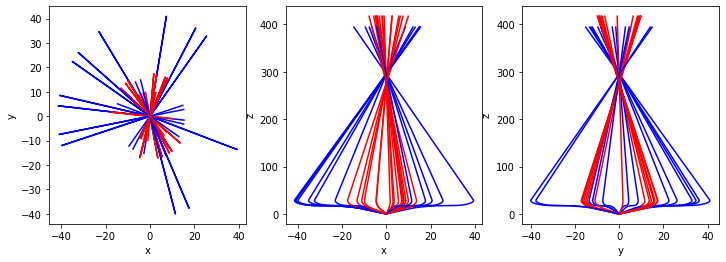

In [407]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 0], positions[i][:, 1], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('y')

ax = fig.add_subplot(1, 3, 2)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 0], positions[i][:, 2], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('z')

ax = fig.add_subplot(1, 3, 3)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 1], positions[i][:, 2], color=color)
  ax.set_xlabel('y')
  ax.set_ylabel('z')

plt.show()


Results in 3D

In [408]:
import matplotlib as mpl

Text(0.5, 0, 'z')

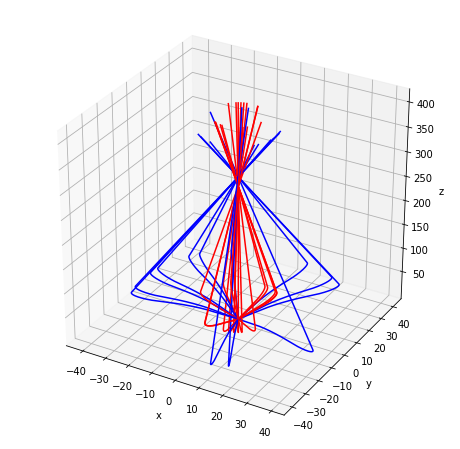

In [409]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue'  
  ax.plot3D(positions[i][:, 0], positions[i][:, 1], positions[i][:, 2], color=color)
'''
B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([60, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
ax.plot3D(B_axis[:, 0], 
         B_axis[:, 1],
         B_axis[:, 2])
'''         
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
#ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], "B field")

Just for fun: found an example how to make a movie.

In [410]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [411]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [412]:
FRAMES = 50
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
# animation function.  This is called sequentially
def animate(i):

  current_index = int(positions[0].shape[0] / FRAMES * i)
  ax.cla()
      
  for n in range(len(positions)):
      if Q[n]>0:
        color = 'red'
      else:
        color = 'blue'
      ax.plot3D(positions[n][:current_index, 0], 
              positions[n][:current_index, 1], 
              positions[n][:current_index, 2], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')


# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)